In [1]:
import sys
import torch
import transformers
import peft
import trl
import matplotlib.pyplot as plt
from dataclasses import asdict
from torch.utils.data import Subset


sys.path.append('..')

In [2]:
from src import configs


warp_args = configs.WARPArgs()
dataset_args = configs.DatasetArgs()
generation_args = configs.GenerationArgs(max_new_tokens=128, num_return_sequences=4)
train_args = configs.PolicyTrainArgs(per_device_eval_batch_size=4)
lora_args = configs.LoraArgs()
checkpoints_args = configs.CheckpointsArgs(sft_checkpoint='../checkpoints/sft', reward_checkpoint='../checkpoints/reward')
generation_config = transformers.GenerationConfig.from_dict(asdict(generation_args))
pareto_front_weights = [0.0, 0.1, 0.3, 0.5, 0.8, 1.0]

In [3]:
device = torch.device('cuda')
sft = peft.AutoPeftModelForCausalLM.from_pretrained('../checkpoints/sft', device_map=device).eval()
sft_tokenizer = transformers.AutoTokenizer.from_pretrained('../checkpoints/sft', padding_side='left')
reward_model = transformers.AutoModelForSequenceClassification.from_pretrained('../checkpoints/reward', device_map=device).eval()
reward_tokenizer = transformers.AutoTokenizer.from_pretrained('../checkpoints/reward', padding_side='left')

In [4]:
from src import dataset


imdb = dataset.build_imdb_dataset(
    sft_tokenizer,
    min_text_length=dataset_args.min_text_length,
    min_tokens=dataset_args.min_tokens,
    max_tokens=dataset_args.max_tokens,
)

train_dataset = imdb['train']
test_dataset = Subset(imdb['test'], list(range(dataset_args.eval_size)))

In [5]:
from src import policy_trainer


def get_kl_reward_front(checkpoint_path: str) -> dict[str, list[float]]:
    metrics = {'kl': [], 'reward': []}

    for weight in pareto_front_weights:
        trl.set_seed(0)
        warp = peft.AutoPeftModelForCausalLM.from_pretrained(checkpoint_path, device_map=device).eval()

        for sft_param, warp_param in zip(sft.parameters(), warp.parameters()):
            warp_param = warp_param.detach()
            warp_param *= weight
            warp_param += (1 - weight) * sft_param

        trainer = policy_trainer.PolicyTrainer(
            warp,
            sft_tokenizer,
            reward_model,
            reward_tokenizer,
            generation_config,
            warp_args,
            ref_policy=sft,
            training_args=transformers.TrainingArguments(
                output_dir='tmp',
                include_inputs_for_metrics=True,
                batch_eval_metrics=True,
                num_train_epochs=0,
                report_to='none',
                **asdict(train_args)
            ),
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )

        trainer.remove_callback(transformers.PrinterCallback)
        model_metrics = trainer.evaluate()
        metrics['kl'].append(model_metrics['eval_KL'])
        metrics['reward'].append(model_metrics['eval_Reward'])
    
    return metrics

def plot_metrics(metrics: dict[str, list[float]]):
    plt.plot(metrics['kl'], metrics['reward'])
    for weight, kl, reward in zip(pareto_front_weights, metrics['kl'], metrics['reward']):
        plt.text(kl, reward, r'$\eta$=' + str(weight))

    plt.xlabel('KL')
    plt.ylabel('Reward')

# WARP

## 1st iteration

In [5]:
metrics_slerp_0 = get_kl_reward_front('../checkpoints/warp_0')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

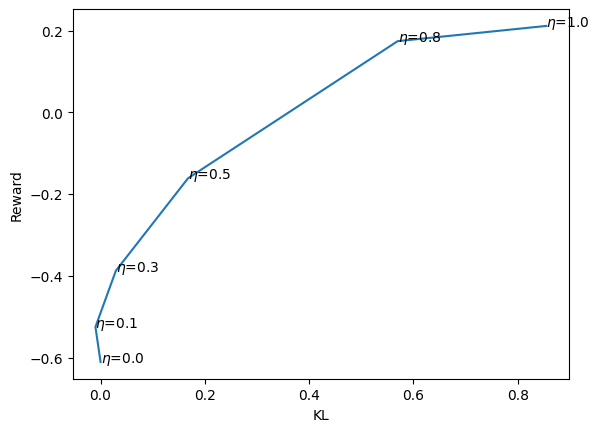

In [13]:
plot_metrics(metrics_slerp_0)

In [14]:
print('KL:', metrics_slerp_0['kl'])
print('Reward:', metrics_slerp_0['reward'])

KL: [-3.0591903305321465e-06, -0.009793374123983085, 0.02936253442429006, 0.16779082166031004, 0.5697384683042764, 0.8548889911174774]
Reward: [-0.6103764646500349, -0.5248588589578866, -0.38735880054533484, -0.16122133292257787, 0.1740150398761034, 0.21127786956727504]


## 2nd iteration

In [6]:
metrics_slerp_1 = get_kl_reward_front('../checkpoints/warp_1')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

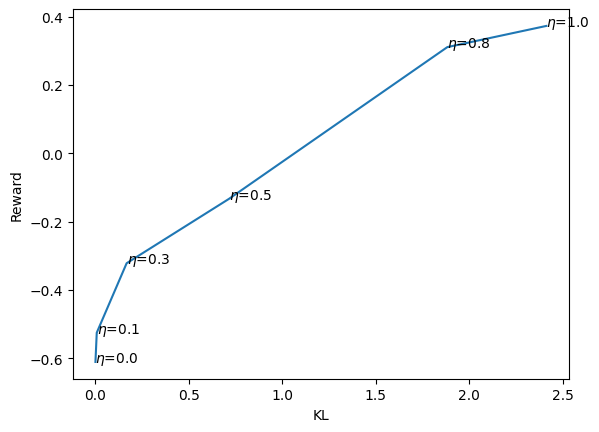

In [7]:
plot_metrics(metrics_slerp_1)

In [8]:
print('KL:', metrics_slerp_1['kl'])
print('Reward:', metrics_slerp_1['reward'])

KL: [-3.0591903305321465e-06, 0.0069868391007184985, 0.16680057443678378, 0.7138086113519967, 1.8817491860315203, 2.4114876396581533]
Reward: [-0.6103764646500349, -0.5248577208817005, -0.321664207354188, -0.13351215951144696, 0.31045583441853525, 0.3724845965206623]


## 3rd iteration

In [6]:
metrics_slerp_2 = get_kl_reward_front('../checkpoints/warp_2')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

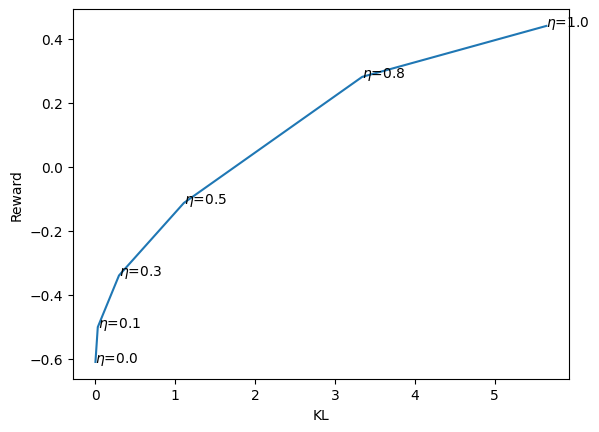

In [7]:
plot_metrics(metrics_slerp_2)

In [8]:
print('KL:', metrics_slerp_2['kl'])
print('Reward:', metrics_slerp_2['reward'])

KL: [-3.0591903305321465e-06, 0.02925147951580584, 0.29494499376043676, 1.1076171464473008, 3.3413127874210478, 5.6478762445598845]
Reward: [-0.6103764646500349, -0.501467631533742, -0.3400614307820797, -0.11333222642540931, 0.28084182009100916, 0.4400232131034136]


# WARP with RLOO

## 1st iteration

In [6]:
metrics_slerp_rloo_0 = get_kl_reward_front('../checkpoints/warp_rloo_0')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

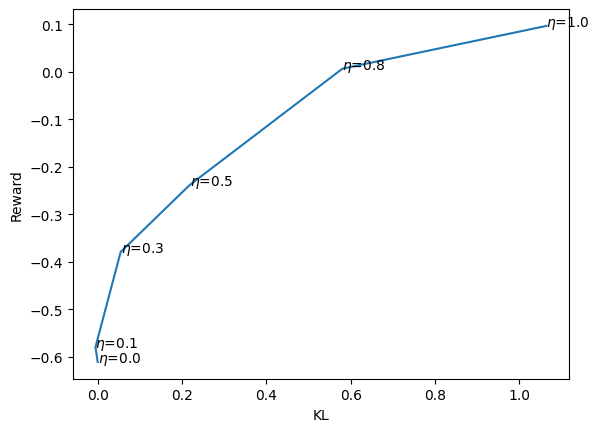

In [7]:
plot_metrics(metrics_slerp_rloo_0)

In [8]:
print('KL:', metrics_slerp_rloo_0['kl'])
print('Reward:', metrics_slerp_rloo_0['reward'])

KL: [-3.0591903305321465e-06, -0.005344628030434251, 0.0544169485475868, 0.21781890803948045, 0.5804766922071576, 1.0642303097620607]
Reward: [-0.6103764646500349, -0.5793937357515097, -0.3792014902085066, -0.2386105742305517, 0.006410333216190338, 0.09631173752248287]


## 2nd iteration

In [6]:
metrics_slerp_rloo_1 = get_kl_reward_front('../checkpoints/warp_rloo_1')

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

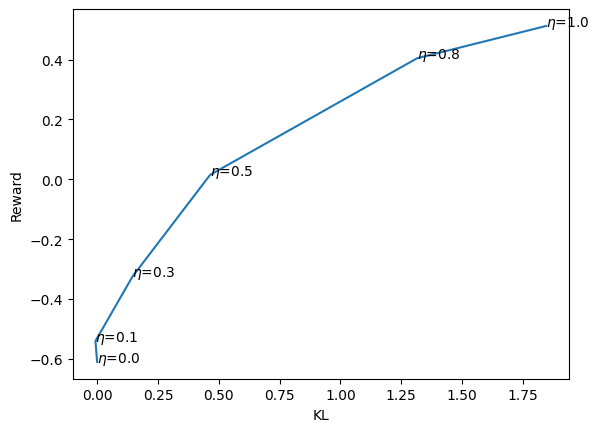

In [7]:
plot_metrics(metrics_slerp_rloo_1)

In [8]:
print('KL:', metrics_slerp_rloo_1['kl'])
print('Reward:', metrics_slerp_rloo_1['reward'])

KL: [-3.0591903305321465e-06, -0.006927336901426316, 0.1453215772099793, 0.4641672273166478, 1.3148425309360028, 1.8460633717849861]
Reward: [-0.6103764646500349, -0.5405778959393501, -0.32495585180819037, 0.014832097440958023, 0.4046743594110012, 0.51276311583817]
